In [8]:
import pandas as pd
import numpy as np

In [10]:
# Dataset original
df = pd.read_csv('data\esets_lung_exprs_genes.txt',sep="\t",header=None,index_col=0)

In [4]:
# Código de Jorge
df2=df.transpose()
df2.columns=df2.columns.fillna('sample_name')
df2['sample_name']=df2['sample_name'].str[:9]
df3=pd.read_csv('data\E-MTAB-6699.sdrf.txt', sep="\t",header=0,index_col=False)
df4=df3.drop(['Extract Name','Factor Value[disease]'],axis=1)
df5=df3.drop(df4,axis=1)
df5['Tumor']=np.where(df5['Factor Value[disease]']=='tumor',1 ,0)
df6=df5.drop(['Factor Value[disease]'],axis=1)
null_columns4=df2.columns[df2.isna().any()]
df2[null_columns4].isna().sum()
df7=df2.merge(df6,how='inner',left_on='sample_name',right_on='Extract Name',left_index=True)
df7.set_index(df7['sample_name'],inplace=True)
df7=df7.drop(['sample_name','Extract Name'],axis=1)
df_caract=df7.drop('Tumor',axis=1)
df_result=df7.drop(df_caract,axis=1)

In [11]:
# Separación de data de entrenamiento 
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df_caract,df_result,test_size=0.1,random_state=42)

In [12]:
# Revisar el tema de los indices, se dropean para probar.
X_train = X_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_train.sample(3)

,RFC2,HSPA6,PAX8,GUCA1A,THRA,PTPN21,CCL5,CYP2E1,EPHB3,ESRRA,...,NAF1,CCDC63,C16orf52,LOC101929475,LOC389641,LOC400499,GALR3,NUS1P3,TMEM231,LOC100505915
805,7.32119867922262,9.04142449450112,8.0502678582012,5.81615126587793,7.04843607859051,7.37808216393539,10.3137321618555,5.55375953095846,7.46279468168173,7.80610494967705,...,6.56912,4.32497,3.48958,4.67824,4.55405,6.5036,5.87382,3.32329,6.45261,5.48111
157,8.06790975589815,4.61664685608931,7.6394967849001,5.77903938860889,7.39958792579677,6.84233218027575,7.21295935046614,7.27190417394847,7.22840658257563,8.37243121155485,...,6.29661,5.10372,3.94315,4.4387,5.60586,6.49402,6.06832,3.96267,6.28983,4.85883
726,8.80391774747977,7.31530352613562,7.63819454592978,5.79097468553756,6.67729587969628,11.2240264562287,7.84980856387603,5.14699739031755,7.28518241521597,7.19611420308093,...,7.07207,4.82039,4.52811,4.57713,4.48568,6.07608,6.38921,4.81714,5.20644,5.74792


In [13]:
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf', random_state = 0, gamma='auto')
svm.fit(X_train, y_train.values.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [14]:
# Data desbalanceada apunta mas a paciente sano
svm.score(X_train, y_train.values.ravel())

0.9882777276825969

In [15]:
# RadomForest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
rfcla = RandomForestClassifier()
rfcla

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
# Un hiperparámetro importante es **n_estimators**, 
# que es la cantidad de árboles que se deben entrenar. 
# Debe ser un valor lo suficientemente grande como para que el error parezca haberse "estabilizado".
# Listar los valores a probar
from sklearn.model_selection import cross_val_score

estimator_range = range(10, 310, 10)

# Definir un lista para almacenar los promedios de los Auc por cada valor de "max_depth"
AUC_scores = []

# Usa una validación cruzada de 5 folds con cada valor del "n_estimators"
for estimator in estimator_range:
    rfcla = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    AUC_score = cross_val_score(rfcla, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc')
    AUC_scores.append(np.mean(AUC_score))
    #print(estimator)

ValueError: x and y must have same first dimension, but have shapes (30,) and (1,)

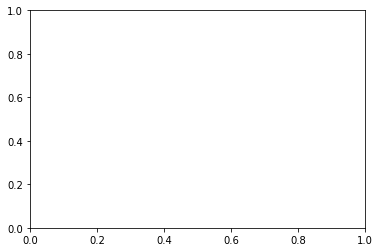

In [62]:
# Graficar n_estimators (eje x) versus AUC (eje y)
import matplotlib.pyplot as plt 

plt.plot(estimator_range, AUC_scores)
plt.xlabel('n_estimators')
plt.ylabel('AUC')

In [ ]:
sorted(zip(AUC_scores, estimator_range), reverse=True)[0]

In [ ]:
# Listar los valores para "max_features"
feature_range = range(1, len(predictores)+1)

# Definir un lista para almacenar los promedios de los Auc por cada valor de "max_features"
AUC_scores = []

# Use una validación cruzada de 10 folds para cada valor de "max_features"
for feature in feature_range:
    rfdec = RandomForestClassifier(n_estimators=150, max_features=feature, random_state=1, n_jobs=-1)
    AUC_score = cross_val_score(rfdec, X, y, cv=10, scoring='roc_auc')
    AUC_scores.append(np.mean(AUC_score))

In [ ]:
# Graficar max_features (eje x) versus AUC (eje y)
plt.plot(feature_range, AUC_scores)
plt.xlabel('max_features')
plt.ylabel('AUC')

In [ ]:
# Mostrar el mejor AUC y su correpondiente "max_features"
sorted(zip(AUC_scores, feature_range), reverse=True)[0]

In [ ]:
# max_features=6 is best and n_estimators=150 is sufficiently large
rfreg = RandomForestRegressor(n_estimators=60, max_features=6, oob_score=True, random_state=1)
rfreg.fit(X, y)

In [ ]:
rfreg.predict(X[5:100])

In [ ]:
rfreg

In [ ]:
# compute feature importances
pd.DataFrame({'feature':predictores, 'importance':rfreg.feature_importances_}).sort_values('importance')

In [ ]:
# compute the out-of-bag R-squared score
rfreg.oob_score_